# One-Dimensional Splines
One-dimensional uniform polynomial splines are functions that map a real number to a
real number. They follow a recipe whereby they are made of the sum of integer-shifted
and weighted basis functions called B-splines. The weights are numbers that parameterize
the spline and give its versatility. The bases are fixed functions that endow the
spline with its unique characteristics—its smoothness, typically. Formally,
we write a spline function $f$ as

$$f:{\mathbb{R}}\rightarrow{\mathbb{R}},\;x\mapsto f(x)=\sum_{k\in{\mathbb{Z}}}\,
c[k]\,\beta^{n}(x-k).$$
There, $c$ are the weights; moreover, $\beta^{n}:{\mathbb{R}}\rightarrow{\mathbb{R}}$
is the polynomial B-spline basis, where the superscript (not the power)
$n\in{\mathbb{N}}$ gives the nonnegative integer degree of the basis. By linearity
(sigma-linearity is not needed here because B-splines have a finite support),
the spline $f$ inherits the properties of continuity and differentiability of the
B-spline $\beta^{n}$.

Let us now focus on the integer translates of a cubic B-spline basis and set $n=3$. It
turns out that the spline built out of them will be made of piecewise (cubic) polynomials
that join in such a way that a general cubic spline can always be differentiated thrice
(but not necessarily four times), and this, for any arbitrary choice of coefficients.

Put simply, cubic splines are rather smooth.

In this formulation, the freedom of choice of the coefficients is what gives splines
their plasticity and allows them to be used as valuable continuously defined models of
data. In particular, the model comes in handy whenever one desires to evaluate the
spline at some arbitrary coordinate $x\in{\mathbb{R}}$, with the purpose of accessing
the value $f(x)$. Even more, the true gradient $\dot{f}$ and the derivatives of higher
order such as $\{\ddot{f}, \dddot{f},\ldots\}$ can also be accessed without having to
resort to finite-difference approximations. This goes a long way to remove one layer
of concern regarding the design of any algorithm that would rely on such differential
quantities.

# Two-Dimensional Spline Curves
So far, we have discussed the one-dimensional spline $f:{\mathbb{R}}\rightarrow{\mathbb{R}}.$
We want now to extend it by one extra dimension. There are two particularly simple ways to do so.
*   Extend the dimension of the functional *domain*, as in
    $f:{\mathbb{R}}^{2}\rightarrow{\mathbb{R}}.$ This approach will typically be followed to handle
    images, with a two-dimensional coordinate (the position) being mapped either to a grayscale value
    or to a value within one channel of a multichannel color image.
*   Extend the dimension of the functional *range*, as in
    ${\mathbf{f}}:{\mathbb{R}}\rightarrow{\mathbb{R}}^{2}.$ This approach will typically be followed
    to handle curves, with a one-dimensional curvilinear coordinate being mapped to a two-dimensional
    coordinate of the plane. This approach is the one we shall be following here.

Let us decide that we want to represent a curve of the plane by a two-component Cartesian coordinate,
each component being itself a spline. If we let $t$ be the curvilinear coordinate, then the curve is

$${\mathbf{f}}:{\mathbb{R}}\rightarrow{\mathbb{R}}^{2},\;t\mapsto{\mathbf{f}}(t)=
\left(\begin{array}{cc}\sum_{k\in{\mathbb{Z}}}\,c_{1}[k]\,\beta^{n}(t-k)\\
\sum_{k\in{\mathbb{Z}}}\,c_{2}[k]\,\beta^{n}(t-k)\end{array}\right).$$
An interesting question that arises is as follows: Is the curve smooth? Certainly, being splines, its
Cartesian components are! To answer in a practical way our question about the smoothness of the
curve as a whole (as opposed to the smoothness of its components in isolation), we provide below a
piece of code that displays ${\mathbf{f}}(t)$ for $t$ over an evolving running window. There, we let
the two series $c_{1}$ and $c_{2}$ of spline coefficients be independent samples of a random variable
that follows a Gaussian normal distribution.

We plot pieces of ${\mathbf{f}}$ either in marroon or green, its knots being indicated by small black
dots. At the leading edge of the curve, we add its osculating circle, which is locally tangent to the
curve and shares its radius of curvature; we display it in lime color when it is on the left of the
curve, and in red color when it is on the right. In the margins of the plot, one can find in yellow
a representation of the horizontal and vertical components of ${\mathbf{f}}.$

The large pink dots are those places of the curve where the radius of the osculating circle is smaller
than some threshold. This means that the curvature is very pronounced there, so that the curve is
possibly singular at such locations. While the components are never singular, we observe that the
(random) curve that is built out of them is singular or nearly singular at surprisingly many places.
Those places where curve singularities exist are called *kinks*; they emerge from the joint interplay
between the gradients and the second-order derivatives of the two Cartesian components of the curve.

The osculating circle has a signed radius. When the radius is negative, the circle is on one side of 
the curve, and is on the other side when the radius is positive. Thus, there are three mechanisms at
work to let the radius cross the zero value and possibly give birth to pink kinks.

*   The least frequent case in which the radius vanishes happens when the curve spirals inwards to a
    limit point and then spirals outwards, *without* a change in the direction of rotation. This
    corresponds to a zero of even multiplicity in the function $\rho(t)$ that maps the curvilinear
    coordinate $t$ to the radius $\rho.$
*   It can also happen that $\rho(t)$ has zeros of odd multiplicity, in which case the radius does change
    sign at those zeros. There, the osculating circle is transfered from one side of the curve to the
    other one, a typical situation in which kinks are observed, often in a configuration where the curve
    starts to spirals inwards, meets a reversal point, and spirals outwards *with* a change in the
    direction of rotation.
*   The most frequent case in which the radius moves from one side of the curve to the other one occurs
    when $\lim_{\tau\rightarrow0^{+}}\rho(t-\tau)=\pm\infty$ and
    $\lim_{\tau\rightarrow0^{+}}\rho(t+\tau)=\mp\infty.$ In those cases, the curve straightens, and the
    osculating circle becomes a straight line at the location where $\rho$ is singular. No kink arises
    in this benign situation where the change of side of the osculating circle is graceful.

Finally, fake kinks are observed when the radius of the oscillating circle does not truly vanish, but
just happens to become smaller than the threshold at which kinks are detected.

Output()

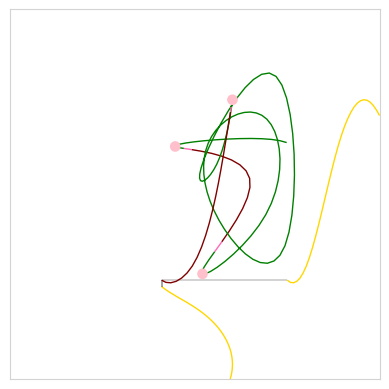

In [33]:
# Load the required libraries.
import ipywidgets as widgets
import math
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import threading
import time
from IPython.display import clear_output
from IPython.display import display
from matplotlib.path import Path

import splinekit as sk # This library

# Setup
support = 15 # Length of the displayed splines
oversampling = 10 # Samples per unit length
hertz = 12 # Refresh rate
kink_initial_radius = 1 / 50 # Initial minimal radius below which the curve is said to have a kink

# Inter-thread communication
thread = threading.local()
thread.out = widgets.Output() # Display
thread.slomo = False # Throttle down the refresh rate
thread.r0 = kink_initial_radius # Adjust the kink threshold
thread.oc = True # Show the osculating circle
thread.kink = True # Show the kinks
thread.knots = True # Show the knots
thread.comp = True # Show the components of the coordinate
thread.resume_event = threading.Event() # Handshake
thread.forever = True # Handshake

# Initialize the plot and loop over updates
def start_animation(thread):
    t = 0 # Initial time
    # Initial continuously defined horizontal component of the spline coordinate
    s1 = sk.PeriodicSpline1D.from_spline_coeff(np.random.standard_normal(support + 2), degree = 3)
    # Initial continuously defined vertical component of the spline coordinate
    s2 = sk.PeriodicSpline1D.from_spline_coeff(np.random.standard_normal(support + 2), degree = 3)
    # Initial samples of the horizontal and vertical components
    x1 = s1.get_samples(0, support_length = support, oversampling = oversampling)
    x2 = s2.get_samples(0, support_length = support, oversampling = oversampling)
    # Initial samples of the gradient of the horizontal and vertical components
    dx1 = s1.gradient().get_samples(0, support_length = support, oversampling = oversampling)
    dx2 = s2.gradient().get_samples(0, support_length = support, oversampling = oversampling)
    # Initial samples of the second-order derivative of the horizontal and vertical components
    ddx1 = s1.differentiated(2).get_samples(0, support_length = support, oversampling = oversampling)
    ddx2 = s2.differentiated(2).get_samples(0, support_length = support, oversampling = oversampling)
    # Initial knots
    isknot = np.array([0 == k % oversampling for k in range(x1.size)], dtype = bool)
    # Precomputed running domain of the horizontal and vertical components
    hk = np.linspace(start = -2.0, stop = -1.0, num = 3 * oversampling)
    vk = np.linspace(start = 1.0, stop = 2.0, num = 3 * oversampling)
    def osculating_signed_radius(k):
        numerator = math.sqrt(dx1[k] ** 2 + dx2[k] ** 2) ** 3
        denominator = dx1[k] * ddx2[k] - ddx1[k] * dx2[k]
        if math.isclose(
            0,
            denominator,
            rel_tol = math.sqrt(math.ulp(1.0)),
            abs_tol = math.sqrt(math.ulp(1.0))
        ):
            if math.isclose(
                0,
                numerator,
                rel_tol = math.sqrt(math.ulp(1.0)),
                abs_tol = math.sqrt(math.ulp(1.0))
            ):
                return float("nan")
            return float("inf") if 0 < denominator else -float("inf")
        return numerator / denominator
    # Initial radiuses of the osculating circles
    r = np.array([osculating_signed_radius(k) for k in range(x1.size)], dtype = float)
    # Initial trailing spline coefficients
    c1 = np.array(s1.spline_coeff[support - 2 : support + 2], dtype = float)
    c2 = np.array(s2.spline_coeff[support - 2 : support + 2], dtype = float)
    # Precomputed B-spline weights
    w = np.array(
        [
            [
                sk.b_spline(1 + t / oversampling - k, 3)
                for k in range(4) # Support of a cubic spline
            ]
            for t in range(oversampling) # One set of weights per shift
        ],
        dtype = float
    )
    # Precomputed B-spline gradient weights
    dw = np.array(
        [
            [
                sk.grad_b_spline(1 + t / oversampling - k, 3)
                for k in range(4) # Support of a cubic spline
            ]
            for t in range(oversampling) # One set of weights per shift
        ],
        dtype = float
    )
    # Precomputed B-spline second-derivative weights
    ddw = np.array(
        [
            [
                sk.diff_b_spline(
                    1 + t / oversampling - k,
                    degree = 3,
                    differentiation_order = 2
                )
                for k in range(4) # Support of a cubic spline
            ]
            for t in range(oversampling) # One set of weights per shift
        ],
        dtype = float
    )

    # Clean slate
    clear_output(wait = False)
    thread["out"].clear_output(wait = False)

    # Allow for pause, resume, and stop Buttons
    toggle_buttons = widgets.ToggleButtons(
        options = ["Pause", "Resume", "Stop"],
        index = 1
    )
    def on_toggle_changed(value):
        if "Pause" == toggle_buttons.value:
            thread["resume_event"].clear()
        elif "Resume" == toggle_buttons.value:
            thread["resume_event"].set()
        elif "Stop" == toggle_buttons.value:
            thread["resume_event"].set()
            thread["forever"] = False
            box.layout.display = "none"
    toggle_buttons.observe(on_toggle_changed, names = "value")
    # Slow motion
    slomo_checkbox = widgets.Checkbox(value = thread["slomo"], description = "Slow Motion")
    def on_slomo_checkbox_changed(value):
        thread["slomo"] = slomo_checkbox.value
    slomo_checkbox.observe(on_slomo_checkbox_changed, names = "value")
    # Allow for the selection of the largest radius of a kink
    flt_range = widgets.FloatSlider(
        min = 0,
        max = 0.1,
        value = thread["r0"],
        step = 0.001,
        readout_format='.3f'
    )
    def on_radius_value_change(change):
        thread["r0"] = flt_range.value
    flt_range.observe(on_radius_value_change, names = "value")
    # Display of the oscillating circle
    oc_checkbox = widgets.Checkbox(value = thread["oc"], description = "Show Osculating Circle")
    def on_oc_checkbox_changed(value):
        thread["oc"] = oc_checkbox.value
    oc_checkbox.observe(on_oc_checkbox_changed, names = "value")
    # Display of the kinks
    kink_checkbox = widgets.Checkbox(value = thread["kink"], description = "Show Kinks")
    def on_kink_checkbox_changed(value):
        thread["kink"] = kink_checkbox.value
    kink_checkbox.observe(on_kink_checkbox_changed, names = "value")
    # Display of the knots
    knots_checkbox = widgets.Checkbox(value = thread["knots"], description = "Show Knots")
    def on_knots_checkbox_changed(value):
        thread["knots"] = knots_checkbox.value
    knots_checkbox.observe(on_knots_checkbox_changed, names = "value")
    # Display of the components of the coordinate
    comp_checkbox = widgets.Checkbox(value = thread["comp"], description = "Show Curve Components")
    def on_comp_checkbox_changed(value):
        thread["comp"] = comp_checkbox.value
    comp_checkbox.observe(on_comp_checkbox_changed, names = "value")
    # Layout of the interactive panel
    box = widgets.VBox([
        widgets.HBox([toggle_buttons]),
        slomo_checkbox,
        widgets.HBox([widgets.Label("Max Kink Radius"), flt_range]),
        oc_checkbox,
        kink_checkbox,
        knots_checkbox,
        comp_checkbox
    ])
    display(box, thread["out"])
    # Layout of the plot
    (fig, ax) = plt.subplots()
    ax.set_aspect(1)
    ax.spines[:].set_color("lightgray")
    plt.tick_params(bottom = False, labelbottom = False, left = False, labelleft = False)
    hdisplay = display("", display_id = True)

    # Update of the plot
    def update_plot(ax, *, hdisplay):
        nonlocal t, x1, x2, dx1, dx2, ddx1, ddx2, isknot, r, c1, c2
        if 0 == t % oversampling:
            t = 0
            isknot[0] = True
            # Innovation, create new trailing coefficients
            c1[0] = np.random.standard_normal()
            c1 = np.roll(c1, -1)
            c2[0] = np.random.standard_normal()
            c2 = np.roll(c2, -1)
        else:
            isknot[0] = False
        x1[0] = w[t] @ c1 # New horizontal component trailing sample
        dx1[0] = dw[t] @ c1 # Horizontal gradient
        ddx1[0] = ddw[t] @ c1 # Horizontal second-order derivative
        x2[0] = w[t] @ c2 # New vertical component trailing sample
        dx2[0] = dw[t] @ c2 # Vertical gradient
        ddx2[0] = ddw[t] @ c2 # Vertical second-order derivative
        r[0] = osculating_signed_radius(0) # Radius of the osculating circle
        # Center of the osculating circle
        o1 = x1[0] - r[0] * dx2[0] / math.sqrt(dx1[0] ** 2 + dx2[0] ** 2)
        o2 = x2[0] + r[0] * dx1[0] / math.sqrt(dx1[0] ** 2 + dx2[0] ** 2)
        # Running window
        x1 = np.roll(x1, -1)
        x2 = np.roll(x2, -1)
        dx1 = np.roll(dx1, -1)
        dx2 = np.roll(dx2, -1)
        ddx1 = np.roll(ddx1, -1)
        ddx2 = np.roll(ddx2, -1)
        isknot = np.roll(isknot, -1)
        r = np.roll(r, -1)
        # New graph
        ax.clear()
        if thread["comp"]: # Show components
            # Horizontal component
            h = np.flip(x1[ : -3 * oversampling - 1 : -1])
            ax.add_patch(patches.PathPatch(Path(np.transpose([h, hk])), fill = False, color = "gold"))
            # Vertical component
            v = x2[ : -3 * oversampling - 1 : -1]
            ax.add_patch(patches.PathPatch(Path(np.transpose([vk, v])), fill = False, color = "gold"))
            ax.add_patch(patches.PathPatch(
                Path([(x1[-1], x2[-1]), (h[-1], hk[-1]), (x1[-1], x2[-1]), (vk[0], v[0])]),
                fill = False,
                color = "k",
                linewidth = 0.25
            )) # Links between the head of the curve and the components
        # Spline curve
        x = np.transpose([x1, x2])
        k = 0
        while k < len(r): # Stretches of radiuses of identical sign
            q = k + 1
            while q < len(r) and 0 < r[k] * r[q]:
                q += 1
            ax.add_patch(
                patches.PathPatch(
                    Path(x[k : q]),
                    color = "maroon" if r[k] < 0 else "green",
                    fill = False
                )
            )
            if q < len(r):
                ax.add_patch(patches.PathPatch(Path(x[q - 1 : q + 1]), color = "hotpink", fill = False))
            k = q
        if thread["oc"]: # Osculating circle
            ax.add_patch(
                patches.Circle(
                    (o1, o2),
                    r[-1],
                    fill = False,
                    color = "r" if r[-1] < 0 else "lime",
                    linewidth = 0.5
                )
            )
        if thread["kink"]: # Kinks
            for k in range(r.size):
                if abs(r[k]) < thread["r0"]:
                    ax.add_patch(patches.Circle((x1[k], x2[k]), 0.05, color = "pink"))
        if thread["knots"]: # Knots
            for k in range(isknot.size):
                if isknot[k]:
                    ax.add_patch(patches.Circle((x1[k], x2[k]), 0.0125, color = "k"))
        # Do plot the graph update
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        plt.close(fig)
        hdisplay.update(fig)
        t += 1

    # Never stop
    while thread["forever"]:
        thread["resume_event"].wait()
        update_plot(ax, hdisplay = hdisplay)
        time.sleep(1.0 if thread["slomo"] else 1.0 / hertz)

# Start the animation and leave
t = threading.Thread(target = start_animation, args = [thread.__dict__])
t.start()
thread.resume_event.set()
